Brian Blaylock  
June 11, 2018

# HRRR Forecasts Graphics
Make the same forecast graphics as shown on my [HRRR fires page](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/hrrr_fires.html).

The real-time script is located here: 
    
    /uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/HRRR_fires.py

Yes, this notebook demonstrates how slow Python can be at making and saving many figures.

In [1]:
%matplotlib inline

import numpy as np
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.dates as mdates
import multiprocessing

import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 100
mpl.rcParams['figure.figsize'] = [15, 6]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'semibold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.01
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 100

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_MesoWest.MesoWest_radius import get_mesowest_radius
from BB_wx_calcs.wind import wind_uv_to_spd, wind_spddir_to_uv
from BB_wx_calcs.units import KtoF, CtoF, mm_to_inches
from BB_data.active_fires import get_fires, get_incidents, download_fire_perimeter_shapefile
from BB_cmap.landuse_colormap import LU_MODIS21
from BB_cmap.reflectivity_colormap import reflect_ncdc

In [2]:
timer = datetime.now()

---

---

---

## Input Location and Forecast Information
You can get latitude and longitude information for a fire on [InciWeb](https://inciweb.nwcg.gov/incident/5834/). You are responsible for making sure the name corresponds to the lat/lon. Set the `DATE` for the model run initialization time. Indicate the forecast hour plots you want by setting `fxx` as a list of forecast hours. Control whether or not to save the images or if you want to overlay available MesoWest data. 

In [3]:
# Use a fire name and InciWeb to find the latitude and longitude of a fire start location
name = 'Burro'
lat = 37.513
lon = -108.111


# HRRR initialization run (year, month, day, hour)
DATE = datetime(2018, 6, 11, 12)


# Forecasts: A list of forecast hours you want to make a plots for.
fxx = range(0,19)


# Saving images
#    False : Do not save the images
#    True  : Save the images in the directory path DIR. If it doesn't exist, make the path
SAVE_IMG = True
DIR = './test/'
if not os.path.exists(DIR):
    os.makedirs(DIR)
    print "Created dir for", DIR 

    
# MesoWest ID
#    False : will not plot MesoWest data
#    STID  : a string being the station ID to compare observations against the HRRR forecasts
MesoWest = 'SKZC2'

Don't need to change things below this...

---

---

---

In [4]:
# Do some data checks
if DATE > datetime.utcnow()-timedelta(hours=1):
    raise ValueError("The requested initialization DATE has not occured yet")
if type(fxx) != list:
    raise ValueError("fxx must be a list")    
for i in fxx:
    if i not in range(0,19):
        raise ValueError("Bad forecast time: %s. Values of fxx must be between 0 and 18" % i)

##### Make the map

In [5]:
half_box = .75 # size of the map area
m = Basemap(resolution='i', projection='cyl',\
            llcrnrlon=lon-half_box, llcrnrlat=lat-half_box,\
            urcrnrlon=lon+half_box, urcrnrlat=lat+half_box,)

##### Make a LandUse map from the HRRR model

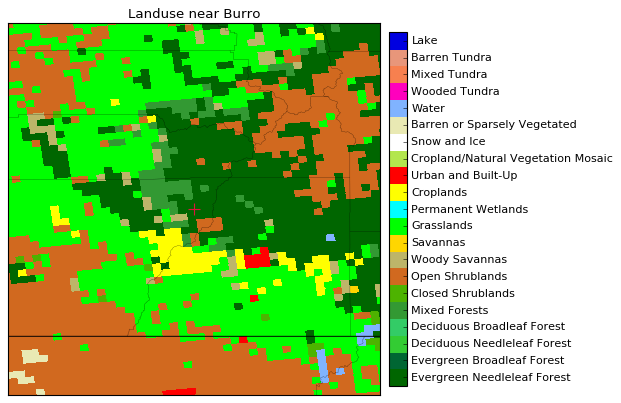

In [6]:
LU = get_hrrr_variable(DATE, 'VGTYP:surface', verbose=False)
cm, labels = LU_MODIS21()

m.pcolormesh(LU['lon'], LU['lat'], LU['value'],
             cmap=cm, vmin=1, vmax=len(labels) + 1,
             latlon=True)
cb = plt.colorbar(orientation='vertical', pad=.01, shrink=.95)
cb.set_ticks(np.arange(0.5, len(labels) + 1))
cb.ax.set_yticklabels(labels)

m.scatter(lon, lat, marker='+', c='crimson', s=100, latlon=True)
m.drawstates()
m.drawcounties()
plt.title('Landuse near %s' % name)

if SAVE_IMG:
    plt.savefig(DIR+'Landuse.png')  

##### Retrieve forecast data for requested model run

In [7]:
DATES, P_tmp = point_hrrr_pollywog(DATE, 'TMP:2 m', lat=lat, lon=lon, verbose=False); print 'got temps'
z, P_dpt = point_hrrr_pollywog(DATE, 'DPT:2 m', lat=lat, lon=lon, verbose=False); print 'got dwpt'
z, P_wind = point_hrrr_pollywog(DATE, 'WIND:10 m', lat=lat, lon=lon, verbose=False); print 'got wind'
z, P_gust = point_hrrr_pollywog(DATE, 'GUST:surface', lat=lat, lon=lon, verbose=False); print 'got gust'
z, P_u, P_v, P_spd = point_hrrr_pollywog(DATE, 'UVGRD:10 m', lat=lat, lon=lon, verbose=False); print 'got U and V wind vectors'
z, P_prec = point_hrrr_pollywog(DATE, 'APCP:surface', lat=lat, lon=lon, verbose=False); print 'got prec'
P_accum = np.add.accumulate(P_prec)

# Convert Units
P_tmp = KtoF(P_tmp)
P_dpt = KtoF(P_dpt)

Point Pollywog: Finished with multiprocessing in 0:00:03.184377 on 22 processors.
got temps
Point Pollywog: Finished with multiprocessing in 0:00:02.813701 on 22 processors.
got dwpt
Point Pollywog: Finished with multiprocessing in 0:00:02.798269 on 22 processors.
got wind
Point Pollywog: Finished with multiprocessing in 0:00:03.174085 on 22 processors.
got gust
Point Pollywog: Finished with multiprocessing in 0:00:08.417206 on 22 processors.
got U and V wind vectors
Point Pollywog: Finished with multiprocessing in 0:00:02.352374 on 22 processors.
got prec


In [8]:
if MesoWest != False:
    a = get_mesowest_ts(MesoWest, DATES[0], DATES[-1],
                        variables='air_temp,wind_speed,dew_point_temperature')

##### Make Figure

In [9]:
def make_fig(f):
    print 'Working on: %s %s F%02d' % (name, DATE.strftime('%Y %b %d %H:%M'), f)
    fig = plt.figure(f+1)
    plt.suptitle('F%02d HRRR Forecast: %s' % (f, name), y=1)

    # Left pannel: Vector Winds and Reflectivity
    ax1 = fig.add_subplot(121)
    m.drawcounties()
    m.drawstates()
    m.arcgisimage(service='World_Shaded_Relief',
                  xpixels=500,
                  dpi=mpl.rcParams['savefig.dpi'],
                  verbose=False)
    m.scatter(lon, lat, s=100, color='white', edgecolor='k', zorder=10, latlon=True)

    # Right-Top: Temperature and Dew Point
    ax2 = fig.add_subplot(322)
    ax2.plot(DATES, P_tmp, c='r', label='Temperature')
    ax2.plot(DATES, P_dpt, c='g', label='Dew Point')
    ax2.grid()
    leg2 = plt.legend()
    leg2.get_frame().set_linewidth(0)
    ax2.set_ylabel('Degrees (F)')
    ax2.set_xlim([DATES[0], DATES[-1]])
    ax2.set_ylim([np.nanmin(P_dpt)-3, np.nanmax(P_tmp)+3])
    ax2.xaxis.set_major_locator(mdates.HourLocator(range(0, 24, 3)))
    ax2.xaxis.set_minor_locator(mdates.HourLocator(range(0, 24, 1)))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter(''))
    if MesoWest != False and a != 'ERROR':
        try:
            ax2.plot(a['DATETIME'], CtoF(a['air_temp']), c='k', ls='--')
        except:
            pass
        try:
            ax2.plot(a['DATETIME'], CtoF(a['dew_point_temperature']), c='k', ls='--')
        except:
            pass

    # Right-Middle: Winds
    ax3 = fig.add_subplot(324)
    ax3.plot(DATES, P_gust, c='chocolate', label='Gust', zorder=1)
    ax3.plot(DATES, P_wind, c='darkorange', label='1 hour max', zorder=1)
    ax3.grid()
    idx = mpl.dates.date2num(DATES)
    for i in range(len(P_u)):
        plt.barbs(idx[i], P_spd[i], P_u[i], P_v[i],
                  length=6,
                  barb_increments=dict(half=2.5, full=5, flag=25), zorder=10)
    leg3 = plt.legend()
    leg3.get_frame().set_linewidth(0)
    ax3.set_ylabel(r'Wind Speed (ms$\mathregular{^{-1}}$)')
    ax3.set_xlim([DATES[0], DATES[-1]])
    ax3.set_ylim([0, np.nanmax(P_gust)+3])
    ax3.set_yticks([0, np.nanmax(P_gust)+3], 2.5)
    ax3.xaxis.set_major_locator(mdates.HourLocator(range(0, 24, 3)))
    ax3.xaxis.set_minor_locator(mdates.HourLocator(range(0, 24, 1)))
    ax3.xaxis.set_major_formatter(mdates.DateFormatter(''))
    if MesoWest != False and a != 'ERROR':
        try:
            ax3.plot(a['DATETIME'], CtoF(a['wind_speed']), c='k', ls='--')
        except:
            pass

    # Right-Bottom: Precipitation
    ax4 = fig.add_subplot(326)
    ax4.bar(DATES, P_prec, width=.04, color='dodgerblue', label='1 hour')
    ax4.plot(DATES, P_accum, color='limegreen', label='Accumulated')
    ax4.grid()
    leg4 = ax4.legend()
    leg4.get_frame().set_linewidth(0)
    ax4.set_ylabel('Precipitation (mm)')
    ax4.set_xlim([DATES[0], DATES[-1]])
    ax4.set_ylim([0, np.nanmax(P_accum)+1])
    ax4.set_yticks([0, np.nanmax(P_accum)+1], .25)
    ax4.xaxis.set_major_locator(mdates.HourLocator(range(0, 24, 3)))
    ax4.xaxis.set_minor_locator(mdates.HourLocator(range(0, 24, 1)))
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d\n%H:%M'))

    
    # Map Reflectivy and Wind vectors
    H = get_hrrr_variable(DATE, 'REFC:entire atmosphere', fxx=f, model='hrrr', verbose=False)
    H_UV = get_hrrr_variable(DATE, 'UVGRD:10 m', fxx=f, model='hrrr', verbose=False)

    # Mask out empty reflectivity values
    dBZ = H['value']
    dBZ = np.ma.array(dBZ)
    dBZ[dBZ == -10] = np.ma.masked

    # Plot reflectivity and vector winds
    plt.sca(ax1)
    plt.pcolormesh(H['lon'], H['lat'], dBZ,
                   cmap=reflect_ncdc(),
                   vmax=80, vmin=0,
                   alpha=.5)
    cb = plt.colorbar(orientation='horizontal', pad=.01, shrink=.6)
    cb.set_label('Simulated Radar Reflectivity (dBZ)\n'+ r'Barbs: Half=2.5 ms$\mathregular{^{-1}}$, Full=5 ms$\mathregular{^{-1}}$, Flag=25 ms$\mathregular{^{-1}}$')

    H_UV = hrrr_subset(H_UV, half_box=35, lat=lat, lon=lon, verbose=False)
    thin = 3
    U_rot, V_rot = m.rotate_vector(H_UV['UGRD'], H_UV['VGRD'], H_UV['lon'], H_UV['lat']) 
    m.barbs(H_UV['lon'][::thin,::thin], H_UV['lat'][::thin,::thin],
            U_rot[::thin,::thin], V_rot[::thin,::thin],
            zorder=200, length=5,
            barb_increments=dict(half=2.5, full=5, flag=25),
            latlon=True)
    
    # Nearby MesoWest:
    if MesoWest != False:
        b = get_mesowest_radius(H['valid'], 15,
                                extra='&radius=%s,%s,60' % (lat, lon),
                                variables='wind_speed,wind_direction')
        if len(b['NAME']) > 0:
            MW_u, MW_v = wind_spddir_to_uv(b['wind_speed'], b['wind_direction'])
            MW_U_rot, MW_V_rot = m.rotate_vector(MW_u, MW_v, b['LON'], b['LAT']) 
            m.barbs(b['LON'], b['LAT'], MW_U_rot, MW_V_rot,
                    color='r',
                    length=4,
                    barb_increments=dict(half=2.5, full=5, flag=25))
        m.scatter(a['LON'], a['LAT'], color='r', s=15, marker='.')
        x, y = m(a['LON']+.01, a['LAT']+.01)
        plt.text(x, y, a['STID'], color='r',  fontsize=9)
    
    ax2.scatter(DATES[f], P_tmp[f], c='r', s=60, zorder=200)
    ax2.scatter(DATES[f], P_dpt[f], c='g', s=60, zorder=200)
    ax3.scatter(DATES[f], P_gust[f], c='chocolate', s=60, zorder=200)
    ax3.scatter(DATES[f], P_wind[f], c='darkorange', s=60, zorder=200)
    ax4.scatter(DATES[f], P_accum[f], c='limegreen', s=60, zorder=200)

    # Title over map
    ax1.set_title('Run: %s F%02d' % (H['anlys'].strftime('%Y-%m-%d %H:%M'), f), loc='left')
    ax2.set_title('Valid: %s' % (H['valid'].strftime('%Y-%m-%d %H:%M')), loc='right')
    
    
    if SAVE_IMG:
        plt.savefig(DIR + '%s_%s_F%02d' % (name, DATE.strftime('%Y-%m-%d_%H%M'), f))
    return fig

Working on: Burro 2018 Jun 11 12:00 F00


/uufs/chpc.utah.edu/sys/installdir/python/2.7.11-c7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3109: RuntimeWarning: invalid value encountered in greater_equal
  farnorth = np.abs(lats+dlat) >= 90.0


Working on: Burro 2018 Jun 11 12:00 F01
Working on: Burro 2018 Jun 11 12:00 F02
Working on: Burro 2018 Jun 11 12:00 F03
Working on: Burro 2018 Jun 11 12:00 F04
Working on: Burro 2018 Jun 11 12:00 F05
Working on: Burro 2018 Jun 11 12:00 F06
Working on: Burro 2018 Jun 11 12:00 F07
Working on: Burro 2018 Jun 11 12:00 F08
Working on: Burro 2018 Jun 11 12:00 F09
Working on: Burro 2018 Jun 11 12:00 F10
Working on: Burro 2018 Jun 11 12:00 F11
Working on: Burro 2018 Jun 11 12:00 F12
Working on: Burro 2018 Jun 11 12:00 F13
Working on: Burro 2018 Jun 11 12:00 F14
Working on: Burro 2018 Jun 11 12:00 F15
Working on: Burro 2018 Jun 11 12:00 F16
Working on: Burro 2018 Jun 11 12:00 F17
Working on: Burro 2018 Jun 11 12:00 F18


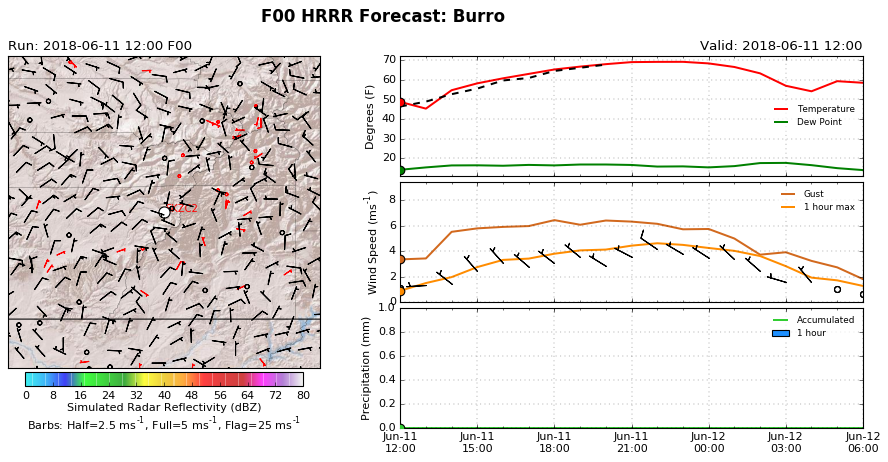

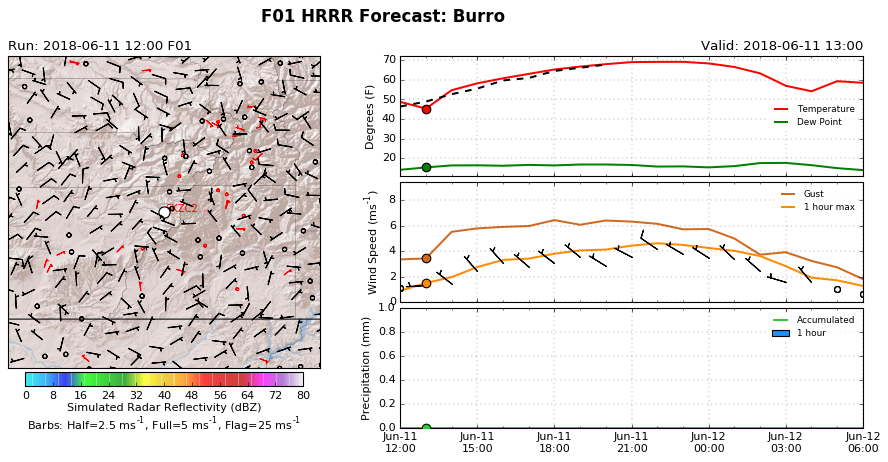

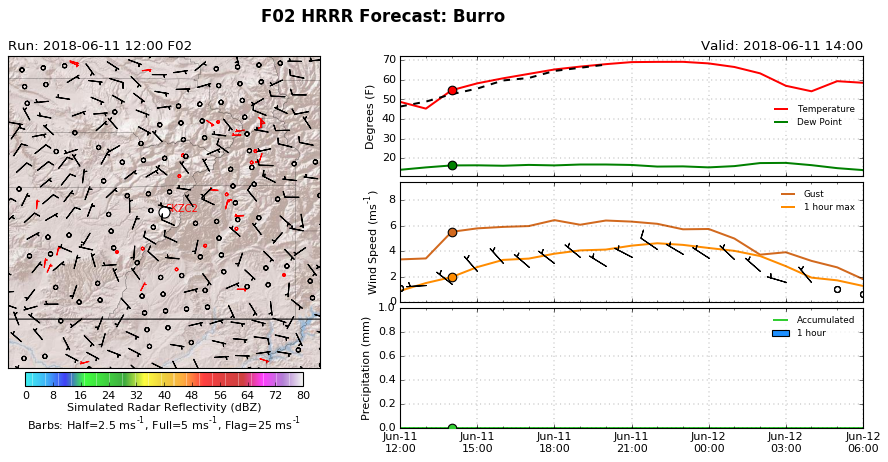

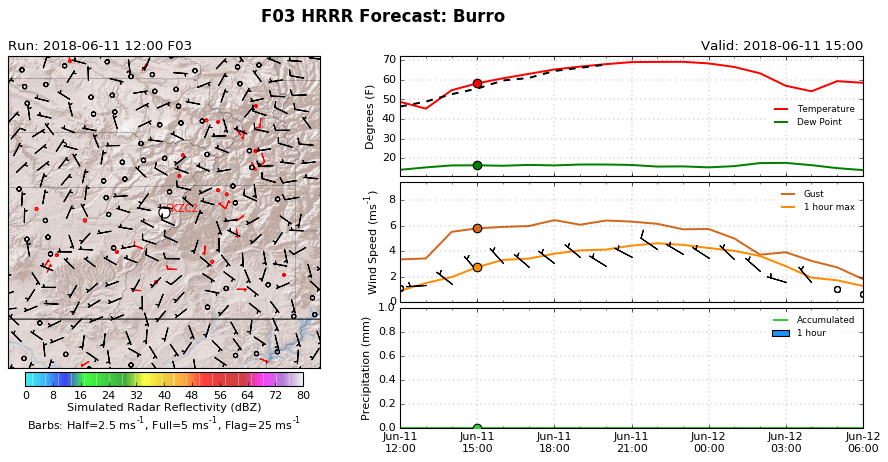

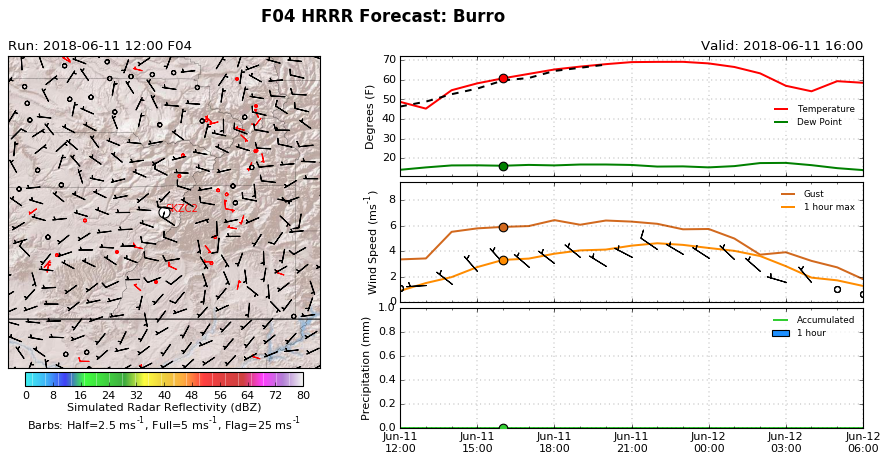

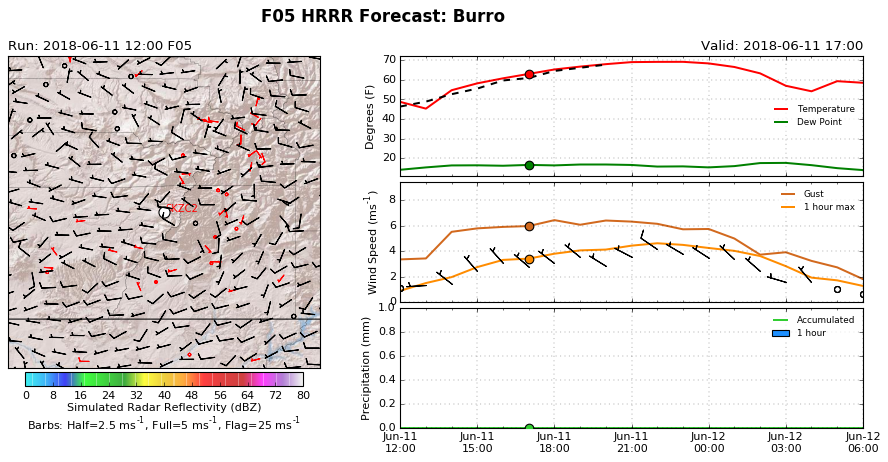

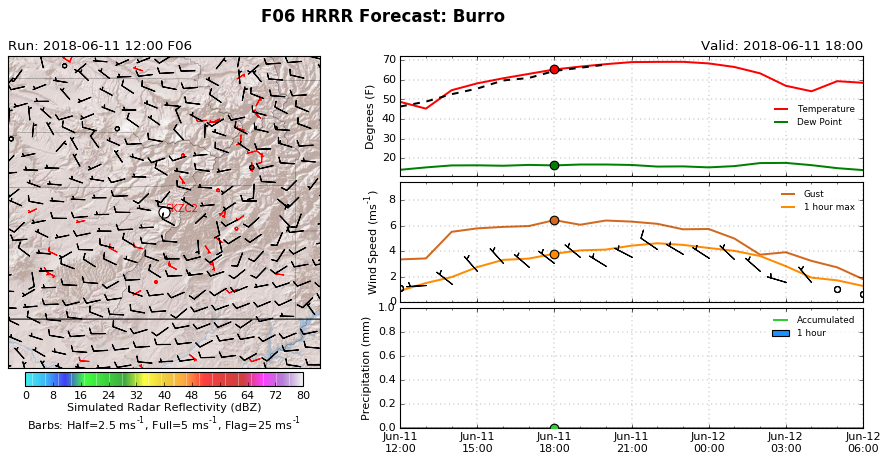

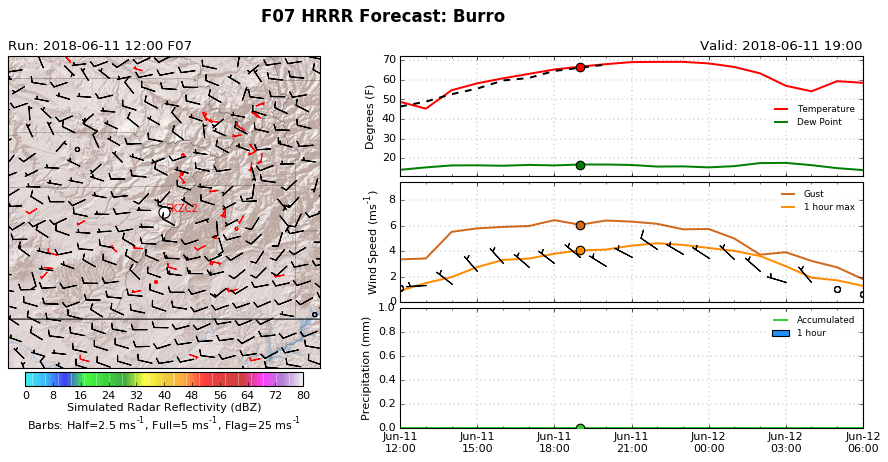

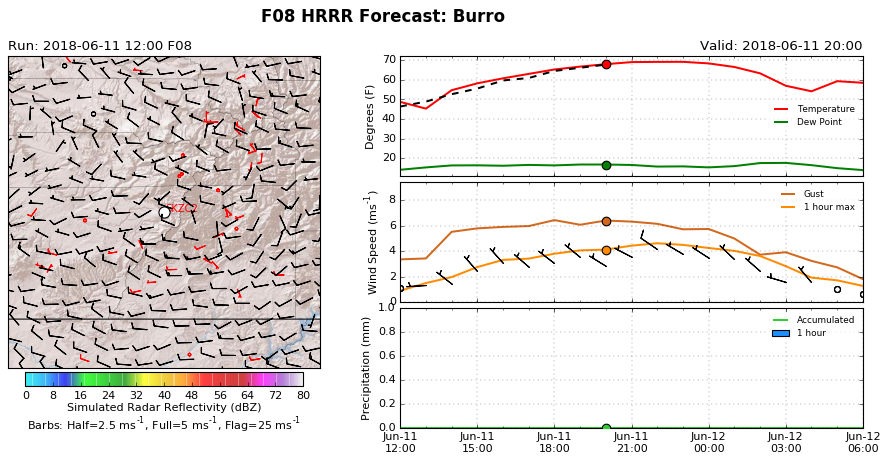

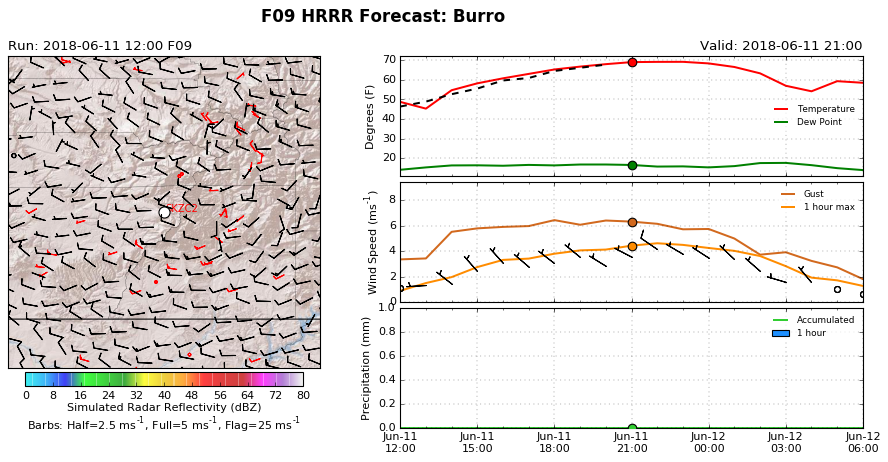

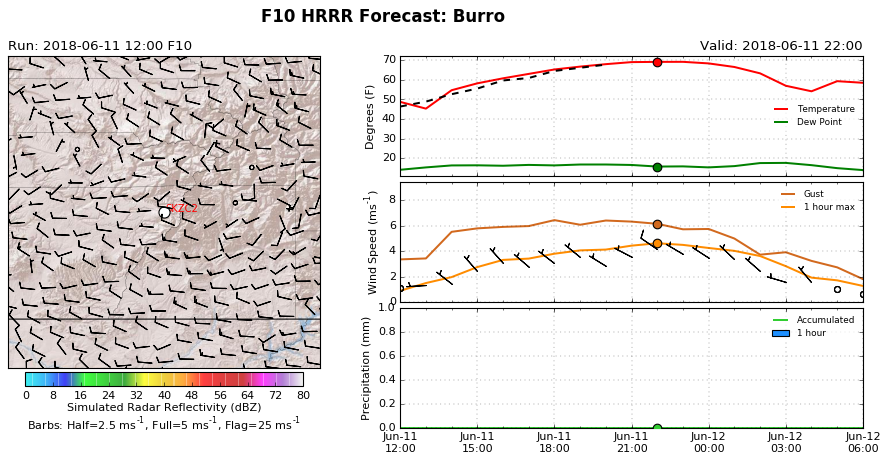

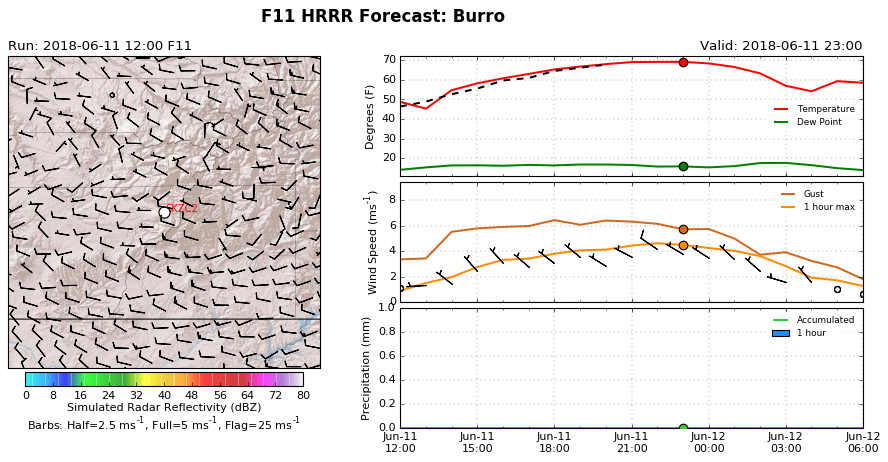

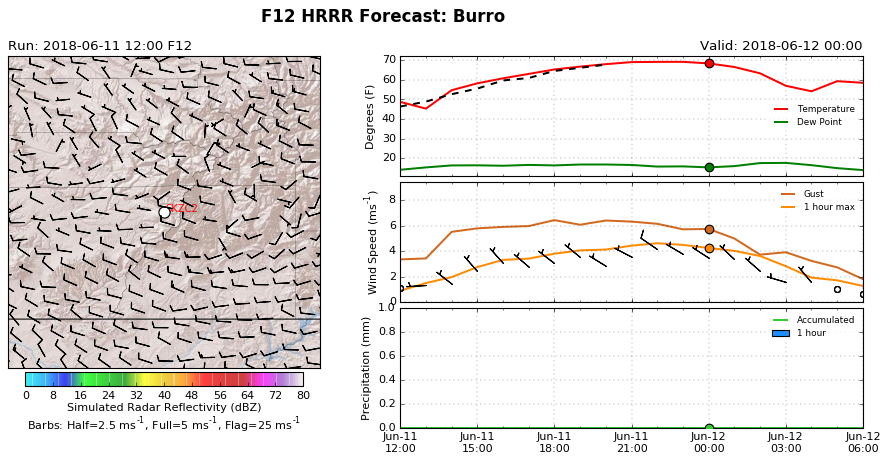

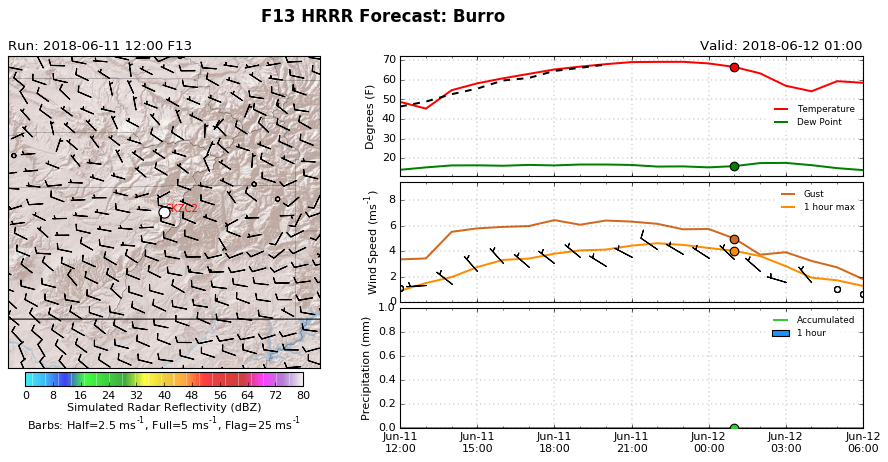

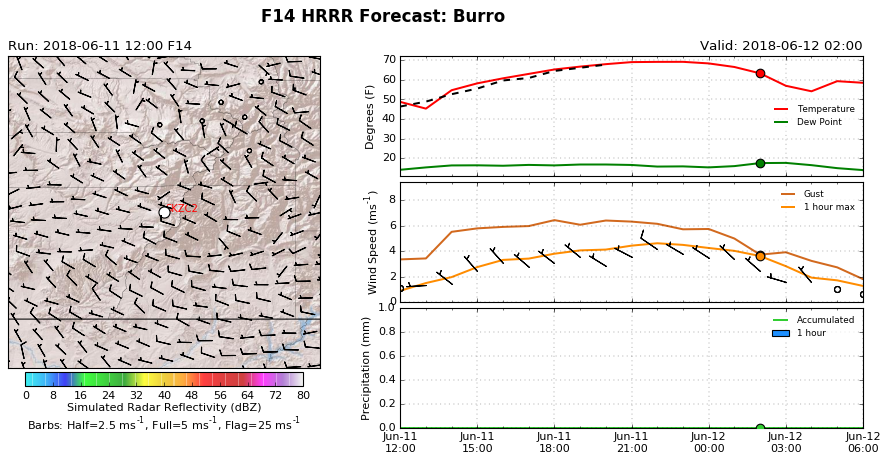

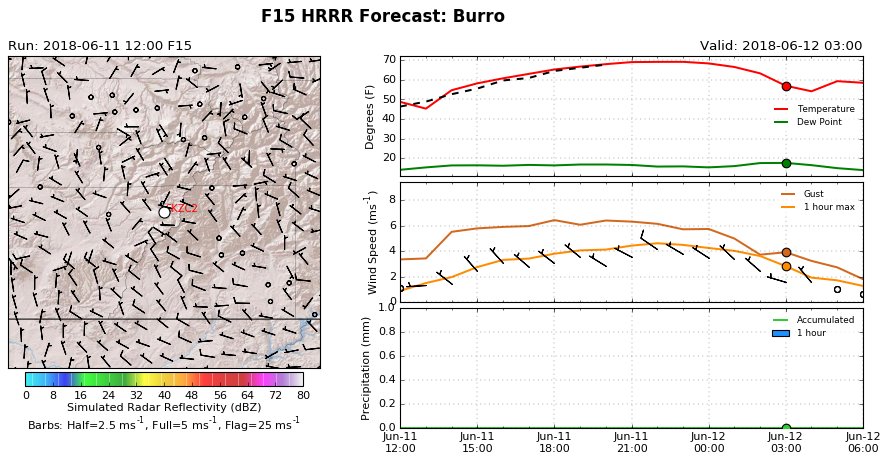

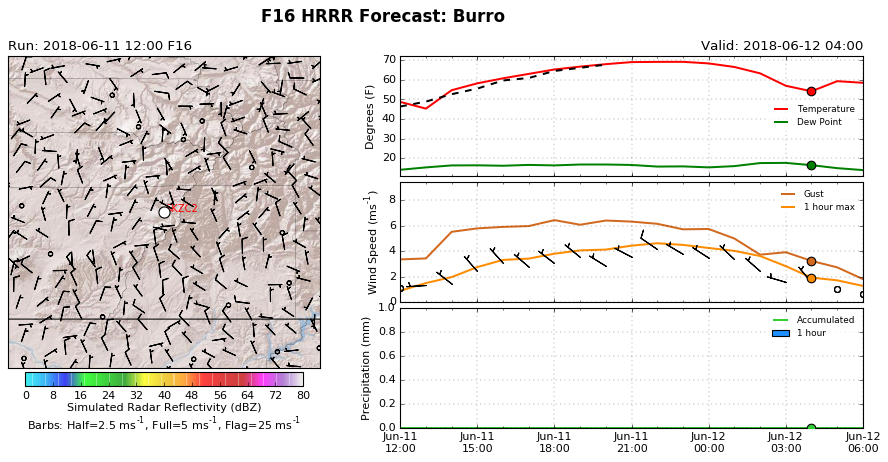

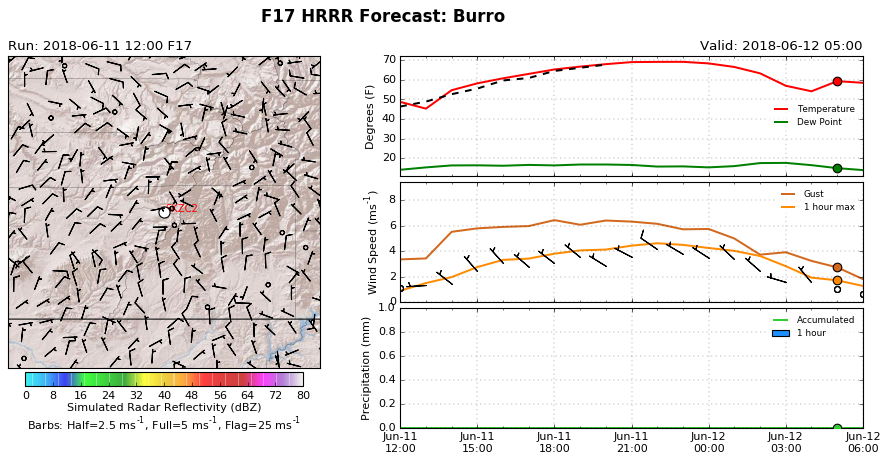

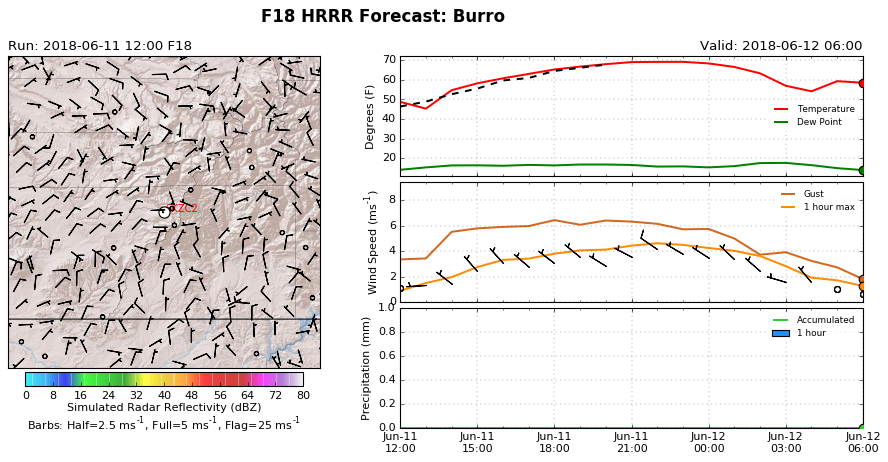

In [10]:
map(make_fig, fxx)

In [11]:
print datetime.now()-timer

0:07:59.895293
